# Laboratório de Processamento de Sinais para Comunicações
##  Prárica 05 - Cancelamento de Ruído

### Aluno - Matrícula:

Ezequias Márcio Silva de Santana Júnior - 371887

In [1]:
import numpy as np
import matplotlib.pylab as plt
import IPython.display as ipd
from scipy.io import wavfile
from scipy import signal
from scipy.linalg import norm

### O sinal

---------Informações---------
Audio: 'googlevoice.wav'
Taxa de amostragem: 48000 Hz
Amostras: (146304, 1)
Duração: 3.048 s



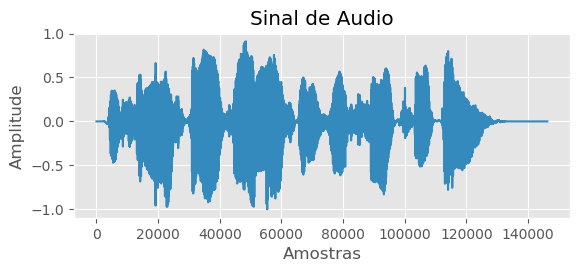

In [2]:
# Carregando audio:
rate, audio = wavfile.read('googlevoice.wav')
# Utilizando apenas um canal (mono) e normalizando as amostras:
audio = audio[:, [1]]/max(abs(audio[:, [1]]))

print(f'''---------Informações---------
Audio: 'googlevoice.wav'
Taxa de amostragem: {rate} Hz
Amostras: {audio.shape}
Duração: {audio.size/rate} s
''')
# Visualização:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Sinal de Audio')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(audio, 'C1')
    plt.show()

# Reprodução:
# wavfile.write('.wav', rate, audio)
ipd.Audio(data=audio.T, rate=rate)

### O ruído

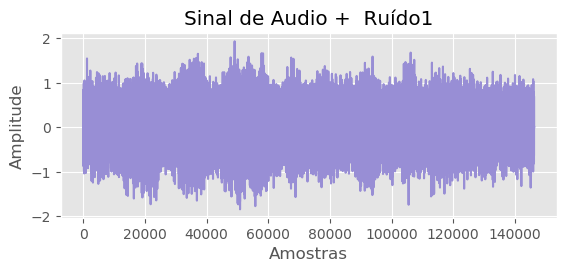

In [3]:
# Construindo ruído:
var = 1e-3 * norm(audio)
noise = np.random.normal(loc=0, scale=np.sqrt(var), size=audio.shape)

# Modelo para o cancelamento:
# Sistema 1:
c1 = 0.5
h1 = signal.dlti([1], [1, -c1])
h1 = signal.dimpulse(h1)   # Resposta ao impulso do Sistema DLTI
h1 = h1[1][0].flatten()       
# Ruído p/ sinal:
noise1 = signal.convolve(noise.flatten(), h1, mode='same')  # Convolução
noise1 = noise1[:, np.newaxis]

# Adição do ruído ao sinal de áudio:
sinal = audio + noise1

# Visualização:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Sinal de Audio +  Ruído1')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(sinal, 'C2')
    plt.show()

# Reprodução:
ipd.Audio(data=sinal.T, rate=rate)

### Definição do filtro adaptativo

In [4]:
# Definição do filtro, LMS:
def least_mean_squares(u, d, step, M):
    
    N = u.size - M + 1      # Número de Iterações
    y = np.zeros((N, 1))    # Saída do filtro
    e = np.zeros((N, 1))    # Erro
    mt_W = np.zeros((M, N)) # Matriz armazenando pesos
    # Algorítimo LMS:
    for n in range(N):
        x = np.flipud(u[n:n + M])[:, np.newaxis]
        y[n] = mt_W[:, [n-1]].T @ x
        e[n] = d[n + M - 1] - y[n]
        # Atualização:
        mt_W[:, [n]] = mt_W[:,[n-1]] + step/norm(x) * x * e[n] # adicionado a normalização
        y[n] = mt_W[:, [n]].T @ x

    return y, e, mt_W


Valor real - Estimativa do filtro:
[[ 1.00e+00  1.00e+00]
 [ 0.00e+00 -7.82e-16]
 [ 0.00e+00  2.61e-16]
 [ 0.00e+00 -8.43e-17]
 [ 0.00e+00 -3.64e-16]
 [ 9.00e+00  9.00e+00]
 [ 0.00e+00 -4.50e-16]
 [ 0.00e+00  8.01e-17]
 [ 0.00e+00  9.64e-17]
 [ 1.00e-01  1.00e-01]]
Valores próx: True


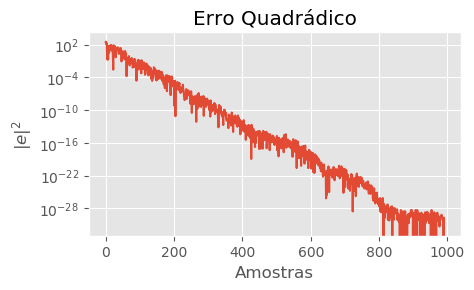

In [5]:
# Exemplo teste:
np.random.seed(0)
coef = np.r_[1, 4*[0], 9, 3*[0], 0.1]
u = np.random.randn(1000)
d = np.convolve(u, coef)

M = 10  # M-taps
step = 0.5
y, e, w = least_mean_squares(u, d, step, M)

np.set_printoptions(2)
print(f'''
Valor real - Estimativa do filtro:
{np.matrix([coef, w[:,-1]]).T}
Valores próx: {np.allclose(w[:,-1], coef)}''')

with plt.style.context('ggplot', True):
    plt.figure(figsize=[0.75*6.4, 0.55*0.75*6.4])
    plt.title('Erro Quadrádico')
    plt.ylabel('$|e|^2$')
    plt.xlabel('Amostras')
    plt.semilogy(np.abs(e)**2)
    plt.show()

### Procedimento de cancelamento
### Caso 1

$H_2(z)=1$ e $H_1(z)$ tem $c_1$ definida com um valor próximo de 0 para atender as condições para a aplicação do filtro.

In [6]:
# Modelo para o cancelamento:
# Sistema 1:
c1 = 0.1
h1 = signal.dlti([1], [1, -c1])
h1 = signal.dimpulse(h1)   # Resposta ao impulso do Sistema DLTI
h1 = h1[1][0].flatten()       
# Ruído p/ sinal:
noise1 = signal.convolve(noise.flatten(), h1, mode='same')  # Convolução
noise1 = noise1[:, np.newaxis]

# Adição do ruído ao sinal de áudio:
sinal1 = audio + noise1

# Sistema 2 entrada do filtro adaptativo: 
h2 = signal.dlti([1], [1])  # H2 = 1
h2 = signal.dimpulse(h2)   # Resposta ao impulso do Sistema DLTI
h2 = h2[1][0].flatten()       
# Ruído p/ o filtro:
noise2 = signal.convolve(noise.flatten(), h2, mode='same')  # Convolução
noise2 = noise2[:, np.newaxis]

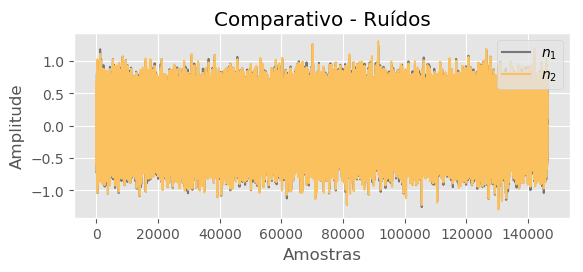

In [7]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Ruídos')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(noise1, 'C3', label='$n_1$')
    plt.plot(noise2, 'C4', label='$n_2$')
    plt.legend()
    
#     plt.figure(figsize=[0.75*6.4, 0.55*0.75*6.4])
#     plt.title('Comparativo - Ruídos')
#     plt.ylabel('Amplitude')
#     plt.xlabel('Amostras')
#     plt.plot(noise, 'C3', label='$n_0$')
#     plt.plot(noise2, 'C4', label='$n_2$')
#     plt.legend()

In [8]:
# Parâmetros:
u1 = noise2.flatten()      # Sinal de entrada do filtro
d = sinal1     # Sinal desejado
M = 100        # Ordem do filtro
step = 0.05 # Passo (ja normalizado na função), tentativa e erro para esse valor.

# Filtragem:
y1, e1, w1 = least_mean_squares(u1, d, step, M)

In [9]:
print(f'Coeficientes do filtro:\n{w1[:,-1]}')

Coeficientes do filtro:
[ 3.93e-13  1.00e+00  1.00e-01  1.00e-02  1.00e-03  1.00e-04  1.00e-05
  1.00e-06  1.00e-07  1.00e-08  1.00e-09  1.00e-10  1.02e-11  1.11e-12
  2.53e-13  3.20e-13  1.13e-13  6.36e-14  1.12e-13 -1.33e-14  1.97e-13
  2.51e-13  2.16e-13  1.17e-13  2.66e-13  4.57e-13  5.12e-13  6.75e-13
  6.29e-13  5.10e-13  3.68e-13  4.94e-13  5.03e-13  4.20e-13  5.15e-13
  5.00e-13  5.70e-13  6.54e-13  6.31e-13  6.75e-13  8.15e-13  5.74e-13
  2.42e-13  8.48e-14  1.57e-13  1.79e-13  2.99e-13  3.43e-13  3.54e-13
  3.26e-13  1.12e-13  2.68e-13  1.59e-13 -1.82e-13 -3.57e-13 -4.14e-13
 -4.59e-13 -4.78e-13 -4.32e-13 -1.01e-13  3.52e-14  4.04e-14  9.38e-14
  5.09e-14  1.55e-13  9.02e-14  5.57e-14  3.32e-14 -1.59e-13 -3.93e-13
 -3.72e-13 -1.16e-13 -1.48e-13 -1.84e-14 -3.53e-14 -2.43e-13 -1.78e-13
 -7.94e-14 -1.64e-13 -2.99e-13 -2.60e-13 -2.49e-13 -3.86e-13 -3.81e-13
 -7.81e-14  2.27e-14 -2.27e-13 -4.23e-13 -2.95e-13 -7.09e-13 -9.28e-13
 -6.14e-13 -5.65e-13 -6.90e-13 -7.90e-13 -3.97e-13 -1

[0, 20, -0.03, 0.08]

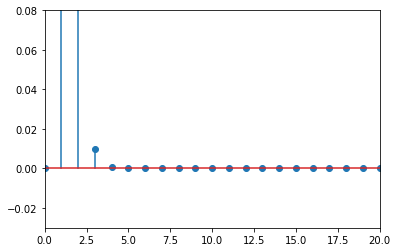

In [10]:
# Rápida visualização dos coeficientes:
plt.stem(w1[:,-1])#, 'o')
plt.axis([0, 20, -0.03, 0.08])

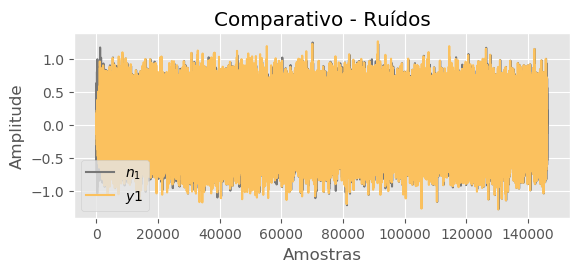

In [11]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Ruídos')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(noise1, 'C3', label='$n_1$')
    plt.plot(y1, 'C4', label='$y1$')
    
    plt.legend()

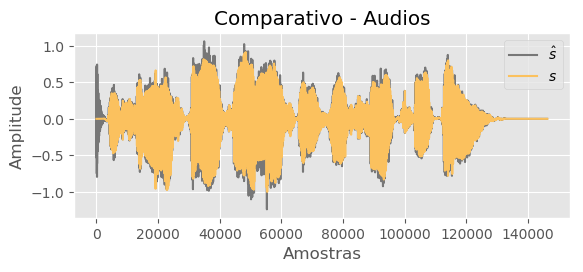

In [12]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Audios')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(e1, 'C3', label='$\hat{s}$')
    plt.plot(audio, 'C4', label='$s$')
    plt.legend()

In [13]:
# Reprodução:
ipd.Audio(data=e1.T, rate=rate)

### Procedimento de cancelamento
### Caso 2

$H_1(z)$ e $H_2(z)$ possuem FT semelhantes e atendem as condições do cancelamento 
com as constantes $c_1$ e $c_2$.

In [14]:
# Modelo para o cancelamento:
# Sistema 1:
c1 = 0.09
h1 = signal.dlti([1], [1, -c1])
h1 = signal.dimpulse(h1)   # Resposta ao impulso do Sistema DLTI
h1 = h1[1][0].flatten()       
# Ruído p/ sinal:
noise1 = signal.convolve(noise.flatten(), h1, mode='same')  # Convolução
noise1 = noise1[:, np.newaxis]

# Adição do ruído ao sinal de áudio:
sinal2 = audio + noise1

# Sistema 2 entrada do filtro adaptativo:
c2 = 0.05
h2 = signal.dlti([1], [1, -c2])
h2 = signal.dimpulse(h2)   # Resposta ao impulso do Sistema DLTI
h2 = h2[1][0].flatten()       
# Ruído p/ o filtro:
noise2 = signal.convolve(noise.flatten(), h2, mode='same')  # Convolução
noise2 = noise2[:, np.newaxis]

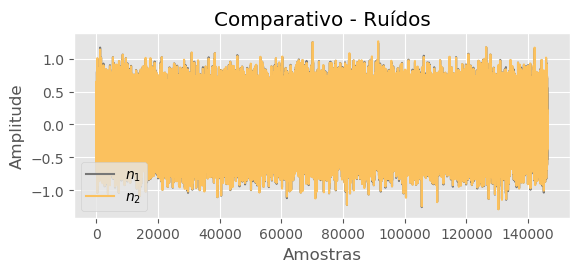

In [15]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Ruídos')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(noise1, 'C3', label='$n_1$')
    plt.plot(noise2, 'C4', label='$n_2$')
    plt.legend()

In [16]:
# Parâmetros:
u2 = noise2.flatten()      # Sinal de entrada do filtro
d = sinal2     # Sinal desejado
M = 100        # Ordem do filtro
step = 0.05  # Passo (normalizado)

# Filtragem:
y2, e2, w2 = least_mean_squares(u2, d, step, M)

In [17]:
print(f'Coeficientes do filtro:\n{w2[:,-1]}')

Coeficientes do filtro:
[ 1.00e+00  4.00e-02  3.60e-03  3.24e-04  2.92e-05  2.62e-06  2.36e-07
  2.13e-08  1.91e-09  1.72e-10  1.55e-11  1.65e-12  1.52e-13 -1.18e-13
  1.84e-13  7.84e-14 -8.53e-14  2.35e-14 -1.05e-14 -4.04e-14  8.67e-14
  3.50e-14 -1.28e-14 -7.18e-14  2.22e-13  6.10e-14 -6.19e-14  2.07e-13
  1.22e-13 -3.37e-15 -1.01e-13  2.28e-13  9.84e-14 -3.10e-14  7.49e-14
  8.45e-14  1.52e-13  1.41e-14  4.77e-15  9.24e-14  2.45e-13 -1.05e-13
 -5.42e-14 -5.32e-14  8.80e-14  2.79e-14  3.27e-14  1.20e-13  1.11e-13
  4.24e-14 -1.10e-13  2.21e-13 -4.95e-14 -9.29e-14 -1.44e-13 -9.97e-14
 -3.61e-14 -1.24e-13 -6.26e-14  4.76e-14  6.81e-14 -2.52e-15 -7.38e-14
  4.85e-15  1.94e-13 -8.01e-14 -2.86e-14  2.77e-14  1.87e-14 -2.01e-13
  1.16e-14  1.13e-13 -1.40e-13  7.69e-14 -1.04e-13 -6.26e-14  3.96e-14
 -2.01e-14 -1.25e-14 -1.84e-13  5.44e-14  4.66e-14 -1.29e-13 -8.26e-14
  2.02e-13  9.79e-14 -2.10e-13 -8.66e-14  1.55e-13 -2.63e-13 -2.67e-13
  7.34e-14 -5.11e-14 -2.34e-13 -1.96e-13  2.00e-13 -6

[0, 20, -0.03, 0.08]

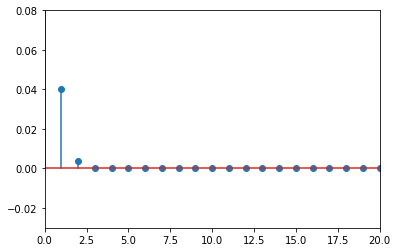

In [18]:
# Rápida visualização dos coeficientes:
plt.stem(w2[:,-1])#, 'o')
plt.axis([0, 20, -0.03, 0.08])

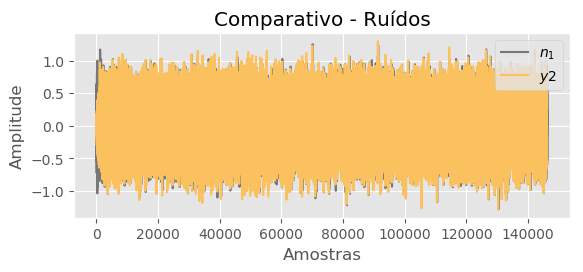

In [19]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Ruídos')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(noise1, 'C3', label='$n_1$')
    plt.plot(y2, 'C4', label='$y2$')
    plt.legend()

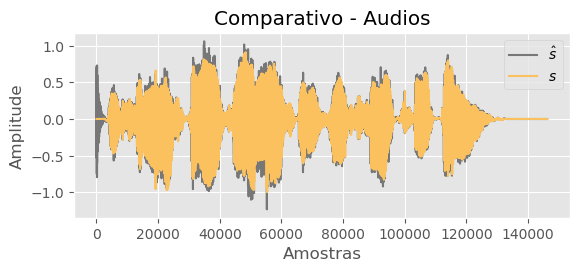

In [20]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Audios')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(e2, 'C3', label='$\hat{s}$')
    plt.plot(audio, 'C4', label='$s$')
    plt.legend()

In [21]:
# Reprodução:
ipd.Audio(data=e2.T, rate=rate)

In [22]:
whos

Variable             Type        Data/Info
------------------------------------------
M                    int         100
audio                ndarray     146304x1: 146304 elems, type `float64`, 1170432 bytes (1.1162109375 Mb)
c1                   float       0.09
c2                   float       0.05
coef                 ndarray     10: 10 elems, type `float64`, 80 bytes
d                    ndarray     146304x1: 146304 elems, type `float64`, 1170432 bytes (1.1162109375 Mb)
e                    ndarray     991x1: 991 elems, type `float64`, 7928 bytes
e1                   ndarray     146205x1: 146205 elems, type `float64`, 1169640 bytes (1.1154556274414062 Mb)
e2                   ndarray     146205x1: 146205 elems, type `float64`, 1169640 bytes (1.1154556274414062 Mb)
h1                   ndarray     100: 100 elems, type `float64`, 800 bytes
h2                   ndarray     100: 100 elems, type `float64`, 800 bytes
ipd                  module      <module 'IPython.display'<...>ages/I

### Idéia questão 02:
Correlações e tentativa da questão 2.

Correlação para identificar o pico e seu índice, indicando quantas amostras foram atrasadas.

Algumas flags em relação as funções internas aparecerão.

In [23]:
# Sistema 2: 
h2 = signal.dlti([1], [1])  # H2 = 1
h2 = signal.dimpulse(h2)   # Resposta ao impulso do Sistema DLTI
h2 = h2[1][0].flatten()       
# Ruído:
noise2 = signal.convolve(noise.flatten(), h2, mode='same')  # Convolução
noise2 = noise2[:, np.newaxis]


Número de amostras do sinal de ruído 2: 146304
Número de amostras do sinal de ruído 1: 146304
Número de amostras da correlação: 292607

Índice de pico anterior: 146352



/home/junior/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/junior/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


Índice de pico com atrasos: 146357

Computando um atraso de 5 amostras



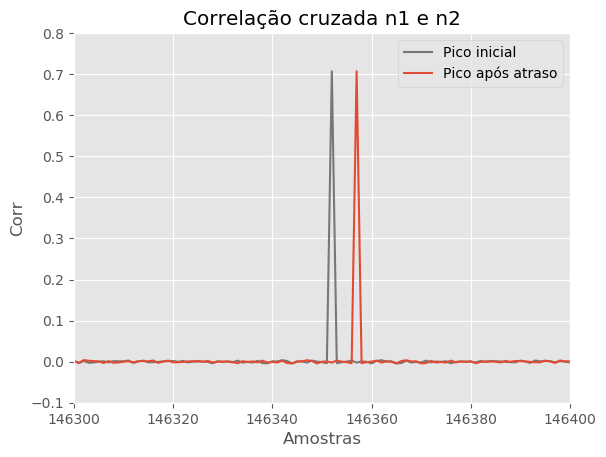

In [24]:
# # Sistema 1: adicionando um delay
noise1 = signal.lfilter(b=[1], a=[1], x=noise.flatten())
noise1 = noise1[:, np.newaxis]

# Correlação cruzada:
a0=signal.correlate(noise1,noise2,mode='full')

print(f'''
Número de amostras do sinal de ruído 2: {noise2.size}
Número de amostras do sinal de ruído 1: {noise1.size}
Número de amostras da correlação: {a0.size}

Índice de pico anterior: {np.argmax(a0)}
''')

# # Sistema 1: adicionando um delay de 5 amostras H(z) = z^-5
noise1 = signal.lfilter(b=[0,0,0,0,0,1], a=[1], x=noise.flatten())
noise1 = noise1[:, np.newaxis]

# Correlação cruzada:
a1=signal.correlate(noise1,noise2,mode='full')

print(f'''Índice de pico com atrasos: {np.argmax(a1)}

Computando um atraso de {np.argmax(a1) - np.argmax(a0)} amostras
''')

with plt.style.context('ggplot', True):
    plt.figure()
    plt.title('Correlação cruzada n1 e n2')
    plt.ylabel('Corr')
    plt.xlabel('Amostras')
    plt.plot(a0/norm(a0), 'C3', label='Pico inicial')
    plt.axis([146300, 146400, -0.1, 0.8])
    plt.plot(a1/norm(a1), 'C0', label='Pico após atraso')
    plt.legend()
    plt.show()